# LightGBM test


## Import libraries

In [1]:
# pip install lightgbm if necessary

!pip install lightgbm


[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

import seaborn as sns

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

from matplotlib.lines import Line2D

import pickle
import shap

from os.path import exists

import math

from sklearn.metrics import accuracy_score

import importlib
# Import local package
from utils import waterfall
# Force package to be reloaded
importlib.reload(waterfall);

import time

Report the time duration to run notebook

In [2]:
start_time = time.time()

## Set up paths and filenames

In [3]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data.'''

    output_save_path: str = './output/'
    data_read_path: str = '../data/kfold_5fold'
    notebook: str = '02_'
    model_text: str = 'xgb_5_features'

paths = Paths()

## Import data

Data has previously been split into 5 stratified k-fold splits.

In [4]:
selected_features = ['prior_disability','stroke_severity','stroke_team',
                     'onset_to_thrombolysis','age']
selected_features.append('discharge_disability')

feature_types = {
    'prior_disability': 'int',
    'stroke_severity': 'int',
    'stroke_team': 'category',
    'onset_to_thrombolysis': 'int',
    'age': 'float',
    'discharge_disability': 'category'
}

train_data, test_data = [], []

train_data, test_data = [], []

def calculate_onset_to_thrombolysis(row):
    # Set default value of onset to thrombolysis of -100 (no thrombolysis given)
    onset_to_thrombolysis = -100
    # Set value if thrombolysis given
    if  row['scan_to_thrombolysis_time'] != -100:
        onset_to_thrombolysis = (row['onset_to_arrival_time'] + 
        row['arrival_to_scan_time'] + row['scan_to_thrombolysis_time'])
    return onset_to_thrombolysis

# Define integer codes for hospitals
loaded_data = pd.read_csv(paths.data_read_path + '/03_train_0.csv')
teams = list(set(loaded_data['stroke_team']))
teams.sort()
teams_code_dict = dict()
for i, j in enumerate(teams):
    teams_code_dict[j] = i 

for i in range(5):
    # Load traing data
    loaded_data = pd.read_csv(paths.data_read_path + f'/03_train_{i}.csv')
    # Calculate onset to thgrombolysis (but set to -100 if no thrombolysis given)
    loaded_data['onset_to_thrombolysis'] = loaded_data.apply(
        calculate_onset_to_thrombolysis, axis=1)
    loaded_data = loaded_data[selected_features]
    loaded_data['stroke_team'] = loaded_data['stroke_team'].map(teams_code_dict)
    # Set types
    for col in list(loaded_data):
        loaded_data[col] = loaded_data[col].astype(feature_types[col])        
    train_data.append(loaded_data)

    # Load test data
    loaded_data = pd.read_csv(paths.data_read_path + f'/03_test_{i}.csv')

    # Calculate onset to thgrombolysis (but set to -100 if no thrombolysis given)
    loaded_data['onset_to_thrombolysis'] = loaded_data.apply(
        calculate_onset_to_thrombolysis, axis=1)
    loaded_data = loaded_data[selected_features]
    loaded_data['stroke_team'] = loaded_data['stroke_team'].map(teams_code_dict)
    # Set types
    for col in list(loaded_data):
        loaded_data[col] = loaded_data[col].astype(feature_types[col])        
    train_data.append(loaded_data)
    test_data.append(loaded_data)

In [5]:
class_names = train_data[0]['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)

## Fit XGBoost model

In [8]:
r_square_kfold = []
roc_auc_ovr_kfold = []
y_pred = []
y_probs = []
y_data = []

# Loop through k folds
for k_fold in range(5):

    # Get k fold split
    train = train_data[k_fold]
    test = test_data[k_fold]

    # Get X and y
    X_train = train.drop('discharge_disability', axis=1)
    X_test = test.drop('discharge_disability', axis=1)
    y_train = train['discharge_disability']
    y_test = test['discharge_disability']
    y_data.append(y_test)

    # Define model
    model = LGBMClassifier(random_state=42)

    # Fit model
    model.fit(X_train, y_train)

    # Get target categories from model
    classes = model.classes_
    y_pred.append(model.predict(X_test))

    # Get predicted probabilities
    probs = model.predict_proba(X_test)
    y_probs.append(probs)

    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test, probs, labels = classes, 
                                multi_class = 'ovr', average = 'macro')
    roc_auc_ovr_kfold.append(roc_auc_ovr)

# Get average result from all k-fold splits
roc_auc_ovr_mean = np.mean(roc_auc_ovr_kfold)

print (f'All features, AUC: {roc_auc_ovr_mean:0.3f} '
       f'(std across 5 kfolds: {np.std(roc_auc_ovr_mean):0.3f})')

All features, AUC: 0.819 (std across 5 kfolds: 0.000)


In [9]:
y_pred = np.concatenate(y_pred)
y_probs = np.concatenate(y_probs)
y_data = np.concatenate(y_data)

[]

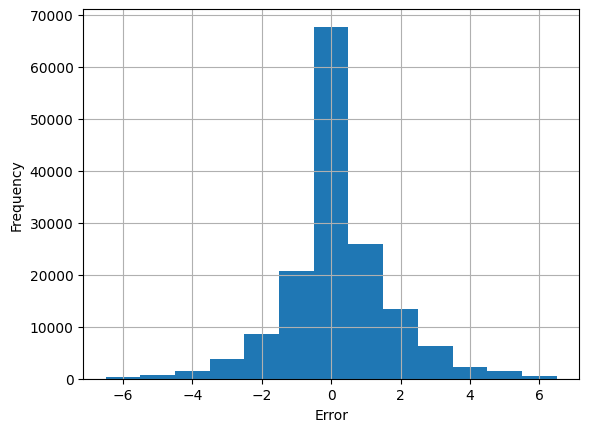

In [10]:
# Calculate error
y_error = pd.Series(y_data - y_pred)
ax = y_error.hist(bins=np.arange(-6.5,6.6))
ax.set_xlabel('Error')
ax.set_ylabel('Frequency')
ax.plot()

Show accuracy (identity)

In [11]:
accuracy = np.mean(y_error==0)
print (f'Accuracy: {accuracy:0.2f}')

error_within_one = np.mean(np.abs(y_error)<=1)
print (f'Error within 1: {error_within_one:0.2f}')

error_within_two = np.mean(np.abs(y_error)<=2)
print (f'Error within 2: {error_within_two:0.2f}')

Accuracy: 0.44
Error within 1: 0.75
Error within 2: 0.89


Show descriptive statistics of error

In [12]:
# Show descriptive statistics of error
pd.Series(y_error).describe().round(2)

count    153078.00
mean          0.20
std           1.54
min          -6.00
25%           0.00
50%           0.00
75%           1.00
max           6.00
dtype: float64

Show descriptive statistics of absolute error

In [13]:
pd.Series(np.abs(y_error)).describe().round(2)

count    153078.00
mean          0.99
std           1.20
min           0.00
25%           0.00
50%           1.00
75%           2.00
max           6.00
dtype: float64

Show regression analysis

In [14]:
# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    scipy.stats.linregress(y_pred, y_data)
r_square = r_value ** 2
y_reg_pred = intercept + (y_data * slope)

print (f'Intercept: {intercept:0.2f}')
print (f'Slope: {slope:0.2f}')
print (f'R-squared: {r_square:0.3f}')
print (f'P-value: {p_value:0.4f}')

Intercept: 1.03
Slope: 0.66
R-squared: 0.447
P-value: 0.0000


# Represent data density with circle size

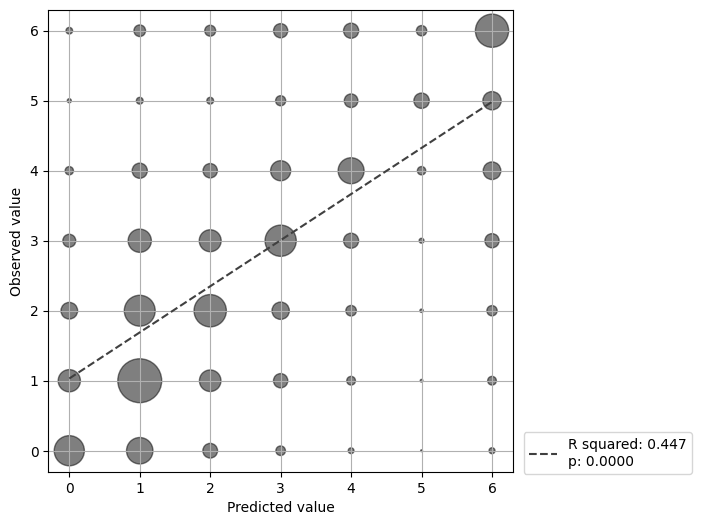

In [15]:
# Create dataframe with two columns (observed and predicted)
plot_data = {"observed": y_pred, "predicted": y_data}
df_obs_pred = pd.DataFrame(plot_data)

# Calculate frequency of each confusion matrix entry, as proportion of maximum frequency
count_categories = df_obs_pred.groupby(["observed", "predicted"]).size()
proportion_categories = count_categories/count_categories.max()

# Create two lists for the available categories
list_y_pred = []
list_y_test = []
for i in range(proportion_categories.index.shape[0]):
    list_y_pred.append(proportion_categories.index[i][0])
    list_y_test.append(proportion_categories.index[i][1])

# Calculate regression line
x_regression = np.arange(0, 7)
y_regression = (x_regression * slope) + intercept

# Scatter plot and regression line
fig = plt.figure(figsize=(6,6))
text = f'R squared: {r_square:.3f}\np: {p_value:0.4f}'
ax1 = fig.add_subplot(111)
ax1.scatter(list_y_pred, list_y_test, edgecolors='black', facecolor='black', alpha=0.5, 
            marker='o', s=proportion_categories.values*1000)

counter = 0
# To add values to plot
#for i, j in zip(list_y_pred, list_y_test):
#    plt.text(i, j, count_categories[i,j], ha='center', va='center', color='w')
#    counter += 1

ax1.plot(x_regression, y_regression, '--', color='0.25', label=text)
ax1.legend(loc='best', bbox_to_anchor=(0.9, -0.4, 0.5, 0.5))
ax1.grid()
ax1.set_xlabel('Predicted value')
ax1.set_ylabel('Observed value')
plt.show()

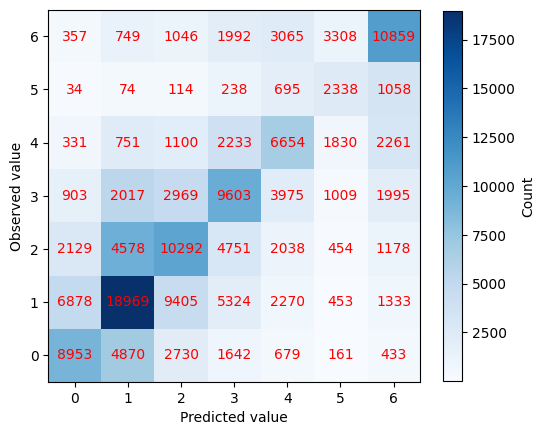

In [16]:
# Show confusion matrix
cm = confusion_matrix(y_data, y_pred)

# Visualize the confusion matrix with colors
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,1,1)
heatmap = plt.imshow(cm, cmap=plt.cm.Blues, origin='lower')
colorbar = plt.colorbar(heatmap, shrink=0.8, ax=ax1, alpha=0.5, label='Count')

# To add values to plot
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(i, j, cm[i][j], ha='center', va='center', color='r')

ax1.set_xlabel('Predicted value')
ax1.set_ylabel('Observed value')
plt.show()

## Convert to binary outcome
Set "Outcome" to 0 for mRS 0-2 (to represent good).
Set "Outcome" to 1 for mRS 3-6 (to represent bad).

In [17]:
# Convert from 0-6 to binary
binary_outcome: dict = {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1}
y_test_binary = (pd.Series(y_data).map(binary_outcome))
y_pred_binary = (pd.Series(y_pred).map(binary_outcome))
y_error_binary = y_test_binary - y_pred_binary
accuracy = np.mean(y_error_binary==0)
print (f'Accuracy: {accuracy:0.2f}')

Accuracy: 0.80


In [18]:
# Get ROC AUC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.7938029416304233


In [19]:
print (f'Regression {r_square:0.3f}')

Regression 0.447


## SHAP

Use last model fit

In [38]:
explainer = shap.TreeExplainer(model)
shap_values_extended = explainer(X_test)

In [39]:
# Shap values exist for each classification in a Tree
# We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
shap_values = shap_values_extended.values

In [40]:
shap_values_extended[0]

.values =
array([[-1.85135267, -1.61761497, -1.59344067,  0.60694384,  0.74286901,
         0.4226044 ,  0.3257419 ],
       [-0.47546735, -0.53413622, -0.28719762, -0.17358309,  0.46814561,
         1.21964262,  0.80159343],
       [ 0.66582157,  0.50597469, -0.18506187, -0.21317872,  0.3204798 ,
         0.05990368, -0.3142636 ],
       [ 0.26076869,  0.2478457 ,  0.08068258, -0.0065008 , -0.10716902,
        -0.28944746, -0.15233442],
       [-0.2555138 , -0.15315529, -0.14551485,  0.12095759,  0.43400565,
         0.40678793,  0.37925835]])

.base_values =
array([-3.09813566, -2.22654076, -2.10266389, -2.04782132, -2.49981141,
       -3.85994617, -2.9034881 ])

.data =
array([  3. ,  14. ,  66. , 131. ,  87.5])

In [104]:
# For LightGBM, need to construct a new object for plotting waterfall
class Shap_array:
    def __init__(self, shap_values_extended, row, class_index):
        self.values = shap_values_extended[row][:, class_index].values
        self.base_values = shap_values_extended[row].base_values[class_index]
        self.data = shap_values_extended[row].data
        self.display_data = shap_values_extended.display_data
        self.feature_names = shap_values_extended.feature_names

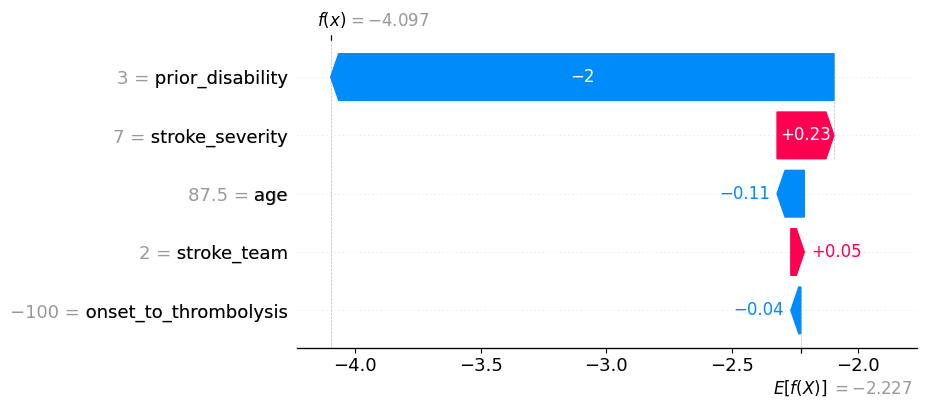

In [109]:
row = 100
class_index = 1

shap.waterfall_plot(Shap_array(shap_values_extended, row, class_index))